In [79]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np


num_arms = 10
mean_boundary = 3
std_boundary = 1

means = mean_boundary*np.random.rand(num_arms)
stds = std_boundary*np.random.rand(num_arms)

tfd = tfp.distributions
RewardDistribution = tfd.Normal(loc = means, scale = stds)
means, stds

(array([0.36459877, 2.10023987, 0.73881794, 0.51746975, 2.77786811,
        2.68345887, 1.17680161, 2.67296608, 0.27654869, 0.7679766 ]),
 array([0.60370601, 0.4364373 , 0.46162246, 0.63501531, 0.74514427,
        0.63646321, 0.6779428 , 0.61418774, 0.47661597, 0.86289117]))

In [80]:
total_steps = 1000
batch_size = 30
epsilon = np.array([0, 0.01, 0.1])

def ep_greedy_bandit(RewardDistribution, epsilon, total_steps, batch_size, init_qval = 0):
    Qval = np.full((batch_size, num_arms), init_qval)
    num_action_select = np.zeros((batch_size, num_arms))
    average_reward = np.zeros((total_steps, batch_size))
    for t in range(total_steps):
        action = ep_greedy_action(Qval, epsilon, batch_size)
        reward = np.zeros(batch_size)
        for n in range(batch_size):
            reward[n] = RewardDistribution[action[n]].sample()

        Qval_update(Qval, action, num_action_select, reward, batch_size)
        average_reward[t] = average_reward[t-1] + (reward - average_reward[t-1])/(t+1) if t>0 else reward
    return average_reward.mean(axis = 1)

def ep_greedy_action(Qval, epsilon, batch_size):
    x = tfd.Bernoulli(probs = epsilon).sample(batch_size)
    ret = np.argmax(Qval, axis = 1)*((x+1)&1) + np.random.randint(num_arms, size = batch_size)*x
    # x[n] == 0 : argmax Qval, x[n] == 1 : random action
    # Bernoulli의 probs parameter는 event 1의 probability를 의미함에 주의하자!
    return ret

def Qval_update(Qval, action, num_action_select, reward, batch_size):
    for n in range(batch_size):
        num_action_select[n][action[n]] += 1
        Qval[n][action[n]] += (reward[n] - Qval[n][action[n]])/num_action_select[n][action[n]]

In [81]:
def plot_result(average_reward, total_steps, label_name):
    plt.plot(range(1, total_steps+1), average_reward, label = label_name)
    plt.legend(loc = 'lower right')

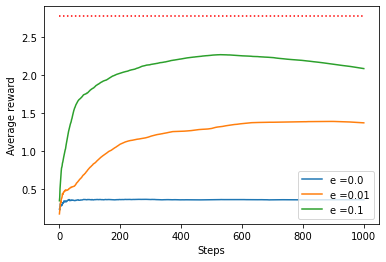

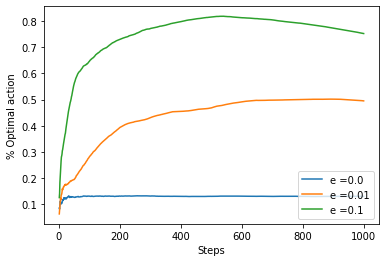

In [82]:
ep_greedy_result = np.zeros((epsilon.size, total_steps))

plt.figure(1)
for n in range(epsilon.size):
    ep_greedy_result[n] = ep_greedy_bandit(RewardDistribution, epsilon[n], total_steps, batch_size)
    plot_result(ep_greedy_result[n], total_steps, 'e ='+str(epsilon[n]))

plt.plot(range(1, total_steps+1), np.full(total_steps, np.max(means)), color = 'r', label = 'optimal', linestyle = 'dotted')
plt.xlabel('Steps')
plt.ylabel('Average reward')

plt.figure(2)
for n in range(epsilon.size):
    plot_result(ep_greedy_result[n]/np.max(means), total_steps, 'e ='+str(epsilon[n]))
plt.xlabel('Steps')
plt.ylabel('% Optimal action')

plt.show()

Q. What is the reason of average reward drop with time steps increasing?

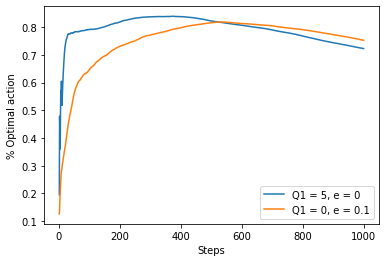

In [83]:
# Comparison between Optimistic Greedy v.s. Realistic epsilon-greedy

optimistic_result = ep_greedy_bandit(RewardDistribution, 0, total_steps, batch_size, 5)
plot_result(optimistic_result/np.max(means), total_steps, 'Q1 = 5, e = 0')

#ep_greedy_result2 = ep_greedy_bandit(RewardDistribution, 0.1, total_steps, batch_size, 0)
plot_result(ep_greedy_result[2]/np.max(means), total_steps, 'Q1 = 0, e = 0.1')

plt.xlabel('Steps')
plt.ylabel('% Optimal action')

plt.show()

In [84]:
#build action selection function for batch learning with UCB 
const = 2

def ucb_bandit(RewardDistribution, const, total_steps, batch_size, init_qval = 0):
    Qval = np.full((batch_size, num_arms), init_qval)
    num_action_select = np.zeros((batch_size, num_arms))
    average_reward = np.zeros((total_steps, batch_size))
    for t in range(total_steps):
        action = ucb_action(Qval, const, t, num_action_select, batch_size)
        reward = get_reward(RewardDistribution, action)

        Qval_update(Qval, action, num_action_select, reward, batch_size)
        average_reward[t] = average_reward[t-1] + (reward - average_reward[t-1])/(t+1) if t>0 else reward
    return average_reward.mean(axis = 1)

def ucb_action(Qval, const, t, num_action_select, batch_size):
    equation = Qval + const*np.sqrt(np.log(t)/num_action_select)
    return np.argmax(equation, axis = 1)

def get_reward(dist, action):
    ret = np.zeros(batch_size)
    for n in range(batch_size):
        ret[n] = dist[action[n]].sample()
    return ret

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


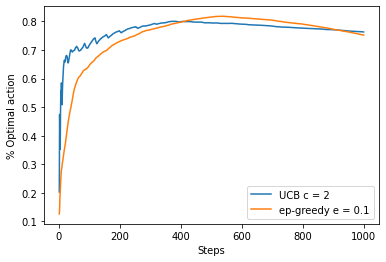

In [85]:
ucb_result = ucb_bandit(RewardDistribution, const, total_steps, batch_size)

plot_result(ucb_result/np.max(means), total_steps, 'UCB c = '+str(const))
plot_result(ep_greedy_result[2]/np.max(means), total_steps, 'ep-greedy e = 0.1')

plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.show()

In [86]:
# build multi-armed bandit algorithm for batch learning with Gradient Bandit
alpha = 0.1

preference = np.zeros((batch_size, num_arms))
def grad_bandit(RewardDistribution, preference, alpha, total_steps, batch_size, use_baseline = False):
    average_reward = np.zeros((total_steps, batch_size))
    for t in range(total_steps):
        policy = get_policy(preference)
        action = get_stoch_action(policy)
        reward = RewardDistribution.sample(batch_size)
        action_reward = get_action_reward(RewardDistribution, action, reward)

        baseline = np.mean(reward, axis = 1) if use_baseline else np.zeros(batch_size)
        pref_update(preference, alpha, action_reward, baseline, action)
        
        average_reward[t] = average_reward[t-1] + (action_reward - average_reward[t-1])/(t+1) if t>0 else action_reward
    return average_reward.mean(axis = 1)

def get_policy(preference):
    return tfd.Categorical(logits = preference)

def get_stoch_action(policy):
    return policy.sample()

def get_action_reward(dist, action, reward):
    action_reward = np.zeros(batch_size)
    for n in range(batch_size):
        action_reward[n] = reward[n][action[n]]
    return action_reward

def pref_update(preference, alpha, action_reward, baseline, action):
    preference += alpha*np.multiply(np.expand_dims(action_reward-baseline, axis = -1), tf.one_hot(action, num_arms) - tf.cast(tf.nn.softmax(preference), float))

In [87]:
def plot_grad_result(average_reward, total_steps, color, thickness, label_name):
    plt.plot(range(1, total_steps+1), average_reward, label = label_name, color = color, alpha = thickness)
    plt.legend(loc = 'lower right')

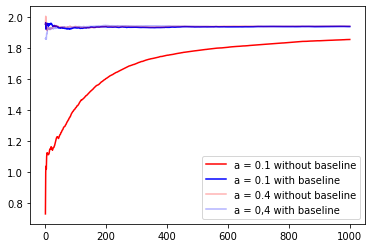

In [88]:
grad_result1 = grad_bandit(RewardDistribution, preference, 0.1, total_steps, batch_size, False)
grad_result1_baseline = grad_bandit(RewardDistribution, preference, 0.1, total_steps, batch_size, True)

grad_result2 = grad_bandit(RewardDistribution, preference, 0.4, total_steps, batch_size, False)
grad_result2_baseline = grad_bandit(RewardDistribution, preference, 0.4, total_steps, batch_size, True)


plot_grad_result(grad_result1/np.mean(means), total_steps, 'r', 1, 'a = 0.1 without baseline')
plot_grad_result(grad_result1_baseline/np.mean(means), total_steps, 'b', 1, 'a = 0.1 with baseline')
plot_grad_result(grad_result2/np.mean(means), total_steps, 'r', 0.3, 'a = 0.4 without baseline')
plot_grad_result(grad_result2_baseline/np.mean(means), total_steps, 'b', 0.3, 'a = 0,4 with baseline')

plt.show()

#????

What is the reason '% Optimal action' for gradient bandits algorithms is above 1?

**Further Study**

1. Get error from Gradient Bandits Algorithm
2. Use other algorithms to compare each other. (Thompson sampling)